In [16]:
import math
class Value:
    def __init__(self,data,children=(),_op='',label=''):
        self.data=data
        self._prev=children
        self.label=label
        self._backward=lambda: None
        self.grad=0
        self._op=_op
    def __repr__(self):
        return f"data={self.data}"
        return data
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data+other.data,(self,other),'+')
        def _backward():
            self.grad+=1*out.grad
            other.grad+=1*out.grad
        out._backward=_backward
        return out
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad+=other.data * out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
    def __rmul__(self,other):
        return self * other
    def __truediv__(self, other):
        return self*other**-1
    def __neg__(self):
        return self*-1
    def __radd__(self, other): # other + self
        return self + other
    def __sub__(self, other):
        return self +(-other)
    def __rsub__(self, other): # other - self
        return other + (-self)
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out
        # c=a*b, d = e*c,,,,, L = d*f,, dl/dc= dl/dd * dd/dc
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supportiing int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward=_backward
        return out
        
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad=(1-(t)**2)*out.grad
        out._backward=_backward
        return out
        
    def backward(self):
        self.grad=1
        topo=[]
        visited=set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()



In [17]:
import math
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [18]:
import numpy as np
import matplotlib.pyplot as plt

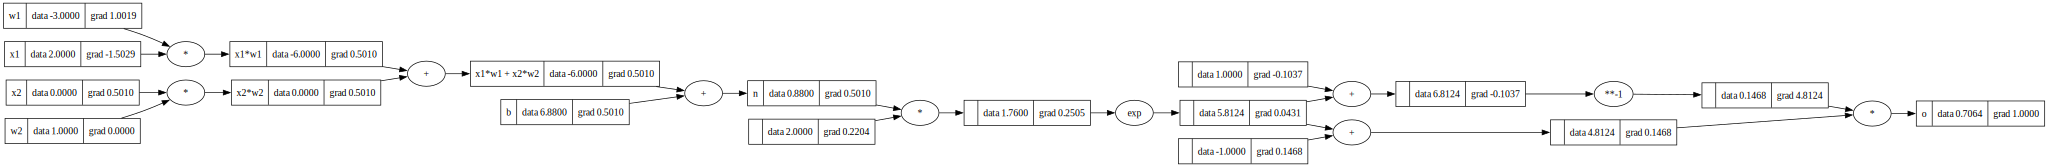

In [19]:
#inputs x1,x2
x1=Value(2.0,label='x1')
x2=Value(0.0, label='x2')
#weights
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
#bias
b=Value(6.88,label='b')

x1w1= x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2
x1w1x2w2.label='x1*w1 + x2*w2'
n=x1w1x2w2 + b
n.label='n'
e= (2*n).exp()
o = (e-1)/(e+1)
o.label='o'
o.backward()
draw_dot(o)


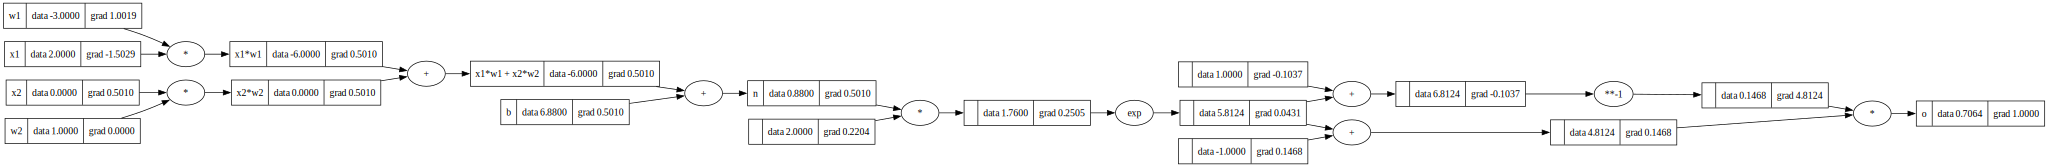

In [20]:
draw_dot(o)


In [21]:
o.grad=1
topo=[]
visited=set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for i in topo:
    i._backward()


In [22]:
o.backward()

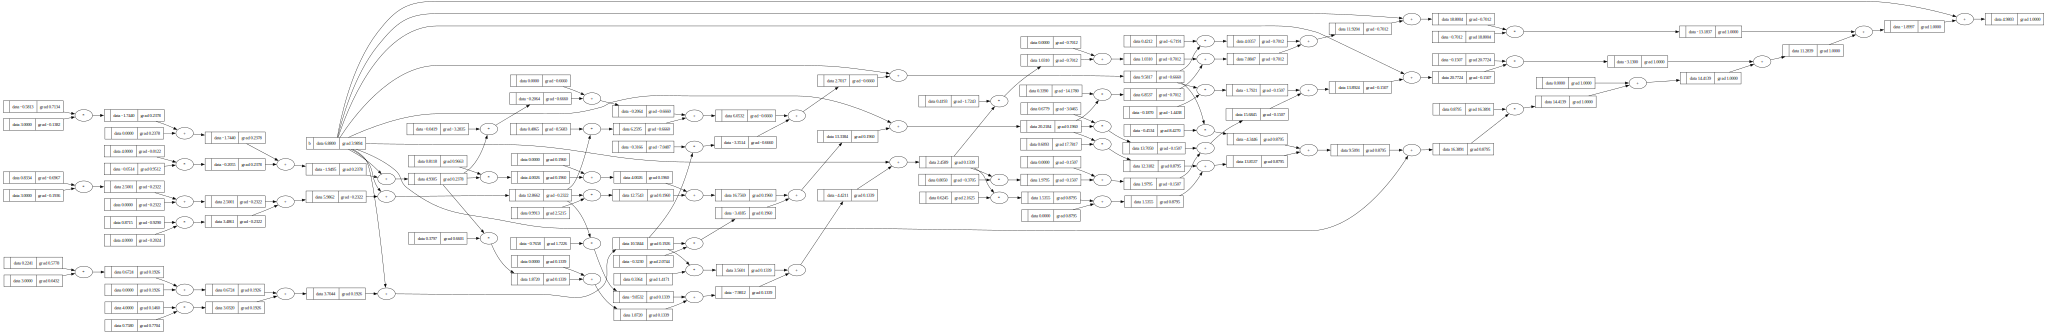

In [23]:
class neurons:
    def __init__(self,nin):
        self.w= [Value(random.uniform(-1,1)) for i in range(nin)]
        self.b=Value(random.uniform(-1,1))

    def __call__(self,x):
        out = sum(wi*xi for wi,xi in zip(self.w,x)) + b
        return out
class layer:
    def __init__(self, nin, nout):
        self.layer=[neurons(nin) for i in range(nout)]
        

    def __call__(self, x):
        out=[n(x) for n in self.layer]
        return out[0] if len(out)==1 else out

class MLP:
    def __init__(self,nin,lay):
        c=[nin]+lay
        self.lay = [layer(c[i],c[i+1]) for i in range(len(lay))]

    def __call__(self, x):
        for lay in self.lay:
            x=lay(x)
        return x
        
        
import random
x=MLP(2,[3,3,3,1])
c=x([3,4])
c.backward()
draw_dot(c)

In [223]:
class neurons:
    def __init__(self, nin):
        self.w=[Value(random.uniform(-1,1)) for i in range(nin)]
        self.b=Value(random.uniform(-1,1))

    def __call__(self,x):
        act=sum(wi*xi for wi, xi in zip(self.w,x))+self.b
        return act.tanh()
    def parameters(self):
        return self.w + [self.b]

class layers:
    def __init__(self, nin, nout):
        self.neurons=[neurons(nin) for i in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
class MLP:
    def __init__(self, nin, nout):
        sz=[nin] + nout
        self.layers=[layers(sz[i],sz[i+1]) for i in range(len(nout))]
    def __call__(self, x):
        for layer in self.layers:
            x=layer(x)
        return x

    def parameters(self):
        thisparam = []
        for layer in self.layers:
            thisparam.extend(layer.parameters())
        return thisparam




In [224]:
n = MLP(3, [4,4,1])

In [225]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]


In [226]:
ypred=[n(x) for x in xs]
loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))
loss

data=8.13350372028556

In [227]:
ypred=[n(x) for x in xs]
loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))
loss


data=8.13350372028556

In [229]:
for k in range(10):
    ypred=[n(x) for x in xs]
    loss = sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred))
    for p in n.parameters():
        p.grad=0.0
    loss.backward()
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
    

0 0.09062339821951365
1 0.07956200706937983
2 0.07078110579051244
3 0.06365304320380044
4 0.05775915466162798
5 0.05280993537028775
6 0.048599068443287145
7 0.04497570968284829
8 0.04182711917492403
9 0.039067409633556004


In [230]:
loss

data=0.039067409633556004